<a href="https://colab.research.google.com/github/nicholasthomson/Group9-Final-INST377F2021/blob/main/2-language-models-lab/2-text-classifier-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text Classification ##

This notebook is based on this Pytorch tutorial: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial
        
In this notebook, we will train a network to learn how to classify the country of a name. In this example, we will tokenize per character rather than per word

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Change directories to point to your data!
data_path = '/content/drive/MyDrive/ColabNotebooks'
specific_path = '/content/drive/MyDrive/ColabNotebooks/data.zip'
#!ls "$root_dir"
root_dir = "/content/data"
data_dir = root_dir + '/data/names'

!unzip '/content/drive/MyDrive/ColabNotebooks/data.zip' -d "$root_dir"

Archive:  /content/drive/MyDrive/ColabNotebooks/data.zip
replace /content/data/data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/data/data/eng-fra.txt  
replace /content/data/data/names/Arabic.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/data/data/names/Arabic.txt  
replace /content/data/data/names/Chinese.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/data/data/names/Chinese.txt  
replace /content/data/data/names/Czech.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/data/data/names/Czech.txt  
replace /content/data/data/names/Dutch.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/data/data/names/Dutch.txt  
replace /content/data/data/names/English.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/data/data/names/English.txt  
replace /content/data/data/names/French.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/data/data/names/French.txt  
r

In [ ]:
# Vocabulary
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(n_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

57
Slusarski


In [ ]:
def findFiles(path): return glob.glob(path)

print(findFiles(data_dir + '/*.txt'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(data_dir + '/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories) # Classes
# print(category_lines)

['/content/data/data/names/Polish.txt', '/content/data/data/names/English.txt', '/content/data/data/names/Chinese.txt', '/content/data/data/names/Dutch.txt', '/content/data/data/names/Irish.txt', '/content/data/data/names/Russian.txt', '/content/data/data/names/Italian.txt', '/content/data/data/names/Japanese.txt', '/content/data/data/names/Portuguese.txt', '/content/data/data/names/Vietnamese.txt', '/content/data/data/names/Arabic.txt', '/content/data/data/names/Scottish.txt', '/content/data/data/names/Korean.txt', '/content/data/data/names/French.txt', '/content/data/data/names/Spanish.txt', '/content/data/data/names/Czech.txt', '/content/data/data/names/Greek.txt', '/content/data/data/names/German.txt']
18


In [ ]:
print(category_lines['Greek'][:5])
print(category_lines['Spanish'])

['Adamidis', 'Adamou', 'Agelakos', 'Akrivopoulos', 'Alexandropoulos']
['Abana', 'Abano', 'Abarca', 'Abaroa', 'Abascal', 'Abasolo', 'Abel', 'Abello', 'Aberquero', 'Abreu', 'Acosta', 'Agramunt', 'Aiza', 'Alamilla', 'Albert', 'Albuquerque', 'Aldana', 'Alfaro', 'Alvarado', 'Alvarez', 'Alves', 'Amador', 'Andreu', 'Antunez', 'Aqua', 'Aquino', 'Araujo', 'Araullo', 'Araya', 'Arce', 'Arechavaleta', 'Arena', 'Aritza', 'Armando', 'Arreola', 'Arriola', 'Asis', 'Asturias', 'Avana', 'Azarola', 'Banderas', 'Barros', 'Basurto', 'Bautista', 'Bello', 'Belmonte', 'Bengochea', 'Benitez', 'Bermudez', 'Blanco', 'Blanxart', 'Bolivar', 'Bonaventura', 'Bosque', 'Bustillo', 'Busto', 'Bustos', 'Cabello', 'Cabrera', 'Campo', 'Campos', 'Capello', 'Cardona', 'Caro', 'Casales', 'Castell', 'Castellano', 'Castillion', 'Castillo', 'Castro', 'Chavarria', 'Chavez', 'Colon', 'Costa', 'Crespo', 'Cruz', 'Cuellar', 'Cuevas', "D'cruz", "D'cruze", 'De la cruz', 'De la fuente', 'Del bosque', 'De leon', 'Delgado', 'Del olmo', 'D

### Make everything into one-hot vector ###

For it to be used (transform into a tensor). Here we are doing a character-based one-hot vector

In [ ]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(letterToTensor('o'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.hidden_comp = nn.Linear(input_size + hidden_size, hidden_size)
        self.output_comp = nn.Linear(input_size + hidden_size, hidden_size)
        self.output2output = nn.Linear(hidden_size, output_size)
        self.tanh_act = nn.Tanh()
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
#         print(x.shape)

        combined = torch.cat((x, hidden), 1)
        hidden = self.hidden_comp(combined)
        hidden = self.tanh_act(hidden)
#         print(hidden.shape)

        output = self.output_comp(combined)
        output = self.tanh_act(output)
#         print(output.shape)
        output = self.output2output(output)
        output = self.lsoftmax(output)
#         print(output.shape)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [ ]:
x = letterToTensor('A')
print(x.shape)
hidden =torch.zeros(1, n_hidden)
hidden = rnn.initHidden()
print(hidden.shape)

output, next_hidden = rnn(x, hidden)
print(output.argmax(-1))
print(output.topk(3).indices)

torch.Size([1, 57])
torch.Size([1, 128])
tensor([7])
tensor([[ 7,  1, 17]])


In [ ]:
x = lineToTensor('Alberto')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(x[0], hidden)
output, next_hidden = rnn(x[1], next_hidden)
output, next_hidden = rnn(x[2], next_hidden)
output, next_hidden = rnn(x[3], next_hidden)
output, next_hidden = rnn(x[4], next_hidden)
output, next_hidden = rnn(x[5], next_hidden)
output, next_hidden = rnn(x[6], next_hidden)
print(output.argmax(-1))

tensor([0])


## Preparing for training! ##

In [ ]:
# Helper function to get the actual category from the best

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Polish', 0)


### Quick way to get training example (Src = Name, Trg = Language) ###

In [ ]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Korean / line = Ma
category = Dutch / line = Schoonenburg
category = Czech / line = Karlovsky
category = Italian / line = Somma
category = Vietnamese / line = Chung
category = Irish / line = Cnaimhin
category = Chinese / line = Tow
category = Chinese / line = Qiu
category = Dutch / line = Klerx
category = Japanese / line = Fuwa


In [ ]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


## Train now!!! ##

In [ ]:
def train(category_tensor, line_tensor, optim, criterion, model):

    model.train()
    hidden = model.initHidden()
    model.zero_grad()

    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)

    # Iterate through the whole line!
    for i in range(line_tensor.size()[0]):
        hidden = hidden.to(device)
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)

    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()

#### Train with the RNN from scrath ####

In [ ]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_basic = RNN(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_basic = model_basic.to(device)
optimizer = optim.SGD(model_basic.parameters(), lr=learning_rate)

n_iters = 10000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor, optimizer, criterion, model_basic)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 50% (0m 14s) 2.7528 Agnusdei / Russian ✗ (Italian)
10000 100% (0m 28s) 1.9238 Fukunaka / Japanese ✓


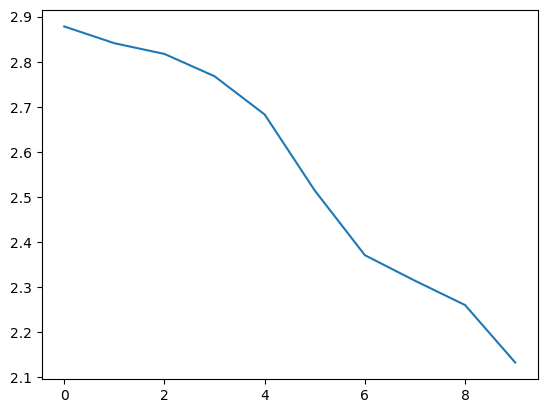

In [ ]:
# PLOT THE RESULT

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluate the results with a confusion matrix! ##

<ipython-input-46-6c681d05ba9d>:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-46-6c681d05ba9d>:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


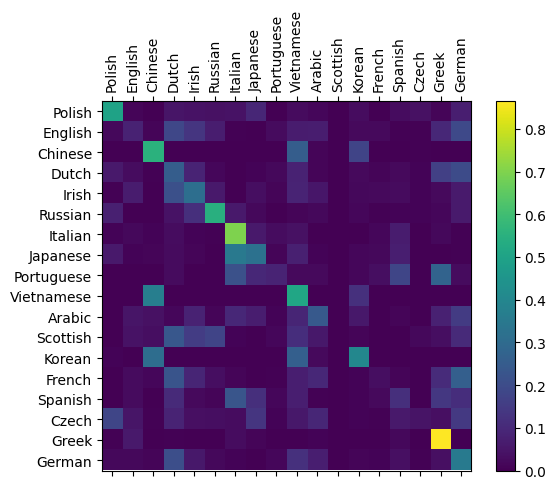

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor, model):
    model.eval()
    hidden = model.initHidden()
    line_tensor = line_tensor.to(device)

    for i in range(line_tensor.size()[0]):
        hidden = hidden.to(device)
        output, hidden = model(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor, model_basic)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Now we can try predicting our own things! ##

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), model_basic)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Alberto')


> Dovesky
(-1.78) Polish
(-1.85) Russian
(-2.48) Dutch

> Jackson
(-1.92) Russian
(-2.14) Dutch
(-2.16) Scottish

> Satoshi
(-1.39) Italian
(-1.85) Polish
(-2.23) Japanese

> Alberto
(-1.57) Italian
(-1.70) Portuguese
(-1.87) Spanish


### So now lets shift to using the RNN Module from Pytorch ###

In [ ]:
def categoryToTensor(category):
#     tensor = torch.zeros([1, 1], dtype=torch.long)
#     tensor[0][0] = all_categories.index(category)
    tensor = torch.zeros([1, len(all_categories)], dtype=torch.long)
    tensor[0][all_categories.index(category)] = 1
    return tensor

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = categoryToTensor(category)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)
#     print(category_tensor.shape)

category = Japanese / line = Tadeshi
category = Polish / line = Kasprzak
category = Dutch / line = Mooren
category = Portuguese / line = De santigo
category = Russian / line = Vaksel
category = Chinese / line = Sha
category = Czech / line = Kaiser
category = Japanese / line = Kimiyama
category = Japanese / line = Shinozaki
category = Vietnamese / line = Lam


In [ ]:
class RNNPytorch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNPytorch, self).__init__()

        self.hidden_size = hidden_size

        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True) # 1 is num_layers
        self.fc = nn.Linear(hidden_size, output_size)
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):

        hidden, output = self.rnn(x, hidden)

        output = output.contiguous().view(-1, self.hidden_size)
        output = self.fc(output)
        output = self.lsoftmax(output)

        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, 1, self.hidden_size)

In [ ]:
def train_pytorch_model(category_tensor, line_tensor, optim, criterion, model):

    model.train()
    hidden = model.initHidden(line_tensor.shape[1])
    model.zero_grad()
    line_tensor = line_tensor.permute(1, 0, 2)
#     print(line_tensor.shape)

#     print(category_tensor.shape)
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)

    # Iterate through the whole line!
    hidden = hidden.to(device)
    output, hidden = model(line_tensor, hidden)

    loss = criterion(output, torch.topk(category_tensor, 1).indices.view(-1))

    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()

#### Train from the RNN using pytorch approach ####

In [ ]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_pytorch = RNNPytorch(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_pytorch = model_pytorch.to(device)
optimizer = optim.SGD(model_pytorch.parameters(), lr=learning_rate)

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_pytorch_model(category_tensor, line_tensor, optimizer, criterion, model_pytorch)
    current_loss += loss
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 11s) 2.1064 Wawrzaszek / Polish ✓
10000 10% (0m 22s) 2.9606 De felice / French ✗ (Italian)
15000 15% (0m 32s) 0.9777 Muyskens / Dutch ✓
20000 20% (0m 42s) 2.3640 Proctor / Portuguese ✗ (English)
25000 25% (0m 53s) 1.7985 Fukao / Vietnamese ✗ (Japanese)
30000 30% (1m 4s) 2.2393 Jiao / Portuguese ✗ (Chinese)
35000 35% (1m 14s) 1.9661 Opova / Irish ✗ (Czech)
40000 40% (1m 24s) 1.0492 She / Korean ✗ (Chinese)
45000 45% (1m 35s) 0.1145 Rossini / Italian ✓
50000 50% (1m 46s) 1.4354 Franke / German ✓
55000 55% (1m 56s) 1.2836 Eldeston / Polish ✗ (English)
60000 60% (2m 7s) 1.5076 Millward / Dutch ✗ (English)
65000 65% (2m 18s) 2.5505 Masson / Scottish ✗ (French)
70000 70% (2m 28s) 0.0318 Kouropoulos / Greek ✓
75000 75% (2m 38s) 0.1596 Campbell / Scottish ✓
80000 80% (2m 49s) 0.0259 Nakatoni / Japanese ✓
85000 85% (3m 0s) 0.1947 Ghanem / Arabic ✓
90000 90% (3m 10s) 0.2147 Fonseca / Portuguese ✓
95000 95% (3m 20s) 0.4987 Chu / Vietnamese ✓
100000 100% (3m 30s) 0.3864 Sung / Korean ✓

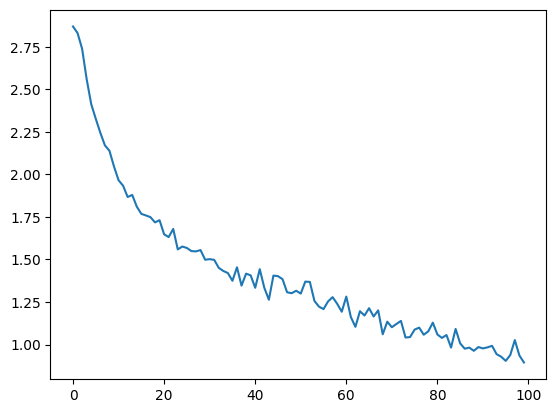

In [ ]:
# PLOT THE RESULT

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [ ]:
# Just return an output given a line
def evaluate(line_tensor, model):
    model.eval()
    hidden = model.initHidden(line_tensor.shape[1])
    hidden = hidden.to(device)

    line_tensor = line_tensor.permute(1, 0, 2)
    line_tensor = line_tensor.to(device)
    output, hidden = model(line_tensor, hidden)

    return output

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), model_pytorch)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Alberto')


> Dovesky
(-1.12) Polish
(-1.23) Russian
(-1.49) Czech

> Jackson
(-0.01) Scottish
(-5.04) English
(-5.59) Russian

> Satoshi
(-0.87) Italian
(-1.03) Japanese
(-1.73) Greek

> Alberto
(-0.44) Portuguese
(-1.62) Italian
(-1.86) Spanish


## Now one of your assigments is to adapt/expand this text classifier! ##

- Adapt the task to another similar task
- Use LSTMs or GRU to compare with both Vanilla RNN approaches

You can keep it at character-level or you can extend it to word-level (the vocabulary will change)

Try with different datasets with a similar Input/Output system:
- Book or character name -> writer
- Game's titles -> company or genre
- Any word -> language
- Whatever you can think it can be classified

In [5]:
import pandas as pd


# Load the video game dataset
print("Loading Video Game Sales dataset from Google Drive...")
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Video_Games_Sales.csv')

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")


Loading Video Game Sales dataset from Google Drive...
Dataset loaded successfully!
Shape: (16719, 16)
Columns: ['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating']


In [6]:
# Clean the data
print("\nCleaning data...")
# Remove rows with missing Name or Genre
df_clean = df.dropna(subset=['Name', 'Genre']).copy()


Cleaning data...


In [7]:
# Show genre distribution and balance the dataset
print("\nOriginal genre distribution:")
genre_counts = df_clean['Genre'].value_counts()
print(genre_counts)

# Balance the dataset - take max 1000 games per genre to avoid bias
balanced_games = []
for genre in genre_counts.index:
    genre_games = df_clean[df_clean['Genre'] == genre]['Name'].tolist()
    # Remove duplicates and limit
    unique_games = list(set(genre_games))
    # Take up to 1000 games per genre
    selected_games = unique_games[:min(1000, len(unique_games))]
    for game in selected_games:
        balanced_games.append((game, genre))

print(f"\nBalanced dataset: {len(balanced_games)} games")


Original genre distribution:
Genre
Action          3370
Sports          2348
Misc            1750
Role-Playing    1500
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       874
Fighting         849
Strategy         683
Puzzle           580
Name: count, dtype: int64

Balanced dataset: 9611 games


In [8]:
# Create balanced genre dictionary
game_genre_lines = {}
for game, genre in balanced_games:
    if genre not in game_genre_lines:
        game_genre_lines[genre] = []
    game_genre_lines[genre].append(game)

game_genres = list(game_genre_lines.keys())
n_game_genres = len(game_genres)

print(f"\nBalanced genres ({n_game_genres} total):")
for genre in game_genres:
    print(f"{genre}: {len(game_genre_lines[genre])} games")


Balanced genres (12 total):
Action: 1000 games
Sports: 1000 games
Misc: 1000 games
Role-Playing: 1000 games
Shooter: 825 games
Adventure: 1000 games
Racing: 772 games
Platform: 588 games
Simulation: 730 games
Fighting: 613 games
Strategy: 585 games
Puzzle: 498 games


In [9]:
# Improved character encoding - include numbers and common punctuation
all_letters = string.ascii_letters + "0123456789 .,;'-:()"
n_letters = len(all_letters)

def letterToIndex(letter):
    if letter in all_letters:
        return all_letters.find(letter)
    else:
        return 0  # Default to first character for unknown chars

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    # Clean the line - remove special characters that aren't in our vocabulary
    cleaned_line = ''.join([c if c in all_letters else ' ' for c in line])
    tensor = torch.zeros(len(cleaned_line), 1, n_letters)
    for li, letter in enumerate(cleaned_line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def randomGameTrainingExample():
    genre = random.choice(game_genres)
    game = random.choice(game_genre_lines[genre])
    genre_tensor = torch.tensor([game_genres.index(genre)], dtype=torch.long)
    game_tensor = lineToTensor(game)
    return genre, game, genre_tensor, game_tensor

def gameFromOutput(output):
    top_n, top_i = output.topk(1)
    genre_i = top_i[0].item()
    return game_genres[genre_i], genre_i

In [10]:
# Improved model architecture
class ImprovedGameRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(ImprovedGameRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Use bidirectional LSTM for better context understanding
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=False, dropout=0.2, bidirectional=True)

        # Adjust for bidirectional output (hidden_size * 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_seq, hidden):
        lstm_out, hidden = self.lstm(input_seq, hidden)

        # Use the last output (forward and backward combined)
        output = lstm_out[-1]
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.fc2(output)
        output = self.log_softmax(output)
        return output, hidden

    def initHidden(self):
        # Bidirectional LSTM needs (num_layers * 2) for hidden states
        return (torch.zeros(self.num_layers * 2, 1, self.hidden_size),
                torch.zeros(self.num_layers * 2, 1, self.hidden_size))


In [11]:
# Training function with better error handling
def train_improved_classifier(genre_tensor, game_tensor, model, optimizer, criterion):
    hidden = model.initHidden()
    model.zero_grad()

    # Skip very short games (less than 3 characters)
    if game_tensor.size()[0] < 3:
        return None, 0

    try:
        for i in range(game_tensor.size()[0]):
            output, hidden = model(game_tensor[i].unsqueeze(0), hidden)

        loss = criterion(output, genre_tensor)
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        return output, loss.item()
    except:
        return None, 0

# Initialize improved model
n_hidden = 128  # Reduced for faster training
improved_model = ImprovedGameRNN(n_letters, n_hidden, n_game_genres, num_layers=2)

criterion = nn.NLLLoss()
learning_rate = 0.01  # Increased learning rate
optimizer = optim.Adam(improved_model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Training with better monitoring
n_iters = 15000
print_every = 2000
plot_every = 500

current_loss = 0
all_losses = []
correct_predictions = 0
total_predictions = 0

start = time.time()

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

print("Training Improved Game Genre Classifier...")
print(f"Balanced dataset with {len(balanced_games)} games across {n_game_genres} genres")
print(f"Training for {n_iters:,} iterations")

for iter in range(1, n_iters + 1):
    genre, game, genre_tensor, game_tensor = randomGameTrainingExample()
    result = train_improved_classifier(genre_tensor, game_tensor, improved_model, optimizer, criterion)

    if result[0] is not None:
        output, loss = result
        current_loss += loss

        # Track accuracy during training
        guess, guess_i = gameFromOutput(output)
        if guess == genre:
            correct_predictions += 1
        total_predictions += 1

    if iter % print_every == 0:
        if result[0] is not None:
            guess, guess_i = gameFromOutput(output)
            correct = '✓' if guess == genre else '✗ (%s)' % genre
            train_acc = correct_predictions / max(total_predictions, 1) * 100
            print('%d %d%% (%s) Loss: %.4f Acc: %.1f%% | %s -> %s %s' %
                  (iter, iter / n_iters * 100, timeSince(start), loss,
                   train_acc, game[:25], guess, correct))

    if iter % plot_every == 0:
        if current_loss > 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

print("Training completed!")
final_train_acc = correct_predictions / max(total_predictions, 1) * 100
print(f"Final training accuracy: {final_train_acc:.1f}%")

Training Improved Game Genre Classifier...
Balanced dataset with 9611 games across 12 genres
Training for 15,000 iterations
2000 13% (4m 36s) Loss: 2.5429 Acc: 8.0% | NCAA Football 98 -> Simulation ✗ (Sports)
4000 26% (9m 31s) Loss: 2.5721 Acc: 7.7% | Rampo -> Strategy ✗ (Adventure)
6000 40% (14m 22s) Loss: 2.4483 Acc: 7.8% | Malice -> Shooter ✗ (Platform)
8000 53% (19m 17s) Loss: 2.4475 Acc: 7.9% | Senran Kagura: Estival Ve -> Misc ✗ (Action)
10000 66% (24m 3s) Loss: 2.4743 Acc: 8.1% | Hiiro no Kakera 3: Aoikur -> Role-Playing ✗ (Adventure)
12000 80% (28m 53s) Loss: 2.5327 Acc: 8.1% | Full House Kiss 2 -> Racing ✗ (Adventure)
14000 93% (33m 40s) Loss: 2.2410 Acc: 8.1% | Rayman 3 -> Platform ✓
Training completed!
Final training accuracy: 8.1%


In [12]:
# Evaluation function
def evaluate_improved(game_tensor):
    improved_model.eval()
    hidden = improved_model.initHidden()

    with torch.no_grad():
        for i in range(game_tensor.size()[0]):
            output, hidden = improved_model(game_tensor[i].unsqueeze(0), hidden)

    improved_model.train()
    return output

def predict_improved(input_game, n_predictions=3):
    print(f'\n> {input_game}')
    with torch.no_grad():
        output = evaluate_improved(lineToTensor(input_game))

        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            genre_index = topi[0][i].item()
            confidence = math.exp(value) * 100  # Convert log probability to percentage
            print('(%.1f%%) %s' % (confidence, game_genres[genre_index]))
            predictions.append([value, game_genres[genre_index]])

# Test with real games from dataset
print("\n" + "="*60)
print("TESTING IMPROVED CLASSIFIER")
print("="*60)

# Test with actual games from each genre
test_examples = []
for genre in game_genres:
    if len(game_genre_lines[genre]) >= 3:
        # Pick 2 random games from each genre
        sample_games = random.sample(game_genre_lines[genre], min(2, len(game_genre_lines[genre])))
        for game in sample_games:
            test_examples.append((game, genre))

print("Testing with real games from dataset:")
for game, actual_genre in test_examples[:10]:  # Test first 10
    print(f"\nExpected: {actual_genre}")
    predict_improved(game)

# Final accuracy test
print("\n" + "="*60)
print("FINAL ACCURACY EVALUATION")
print("="*60)

correct = 0
total = 500  # Reduced for speed

for i in range(total):
    genre, game, genre_tensor, game_tensor = randomGameTrainingExample()
    output = evaluate_improved(game_tensor)
    guess, guess_i = gameFromOutput(output)

    if guess == genre:
        correct += 1

accuracy = correct / total
print(f'Final Test Accuracy: {accuracy:.1%} ({correct}/{total})')

if accuracy < 0.20:  # Less than 20%
    print("\n⚠️  Low accuracy suggestions:")
    print("1. The dataset might need more preprocessing")
    print("2. Some genres might be very similar (Action vs Shooter)")
    print("3. Character-level might not capture enough semantic meaning")
    print("4. Consider word-level encoding for better results")
elif accuracy < 0.40:  # 20-40%
    print("\n✅ Moderate accuracy - good for character-level classification!")
    print("This is reasonable for character-level genre classification")
else:  # 40%+
    print("\n🎉 Good accuracy for this task!")

print(f'\nModel Summary:')
print(f'- Dataset: {len(balanced_games)} balanced games')
print(f'- Genres: {n_game_genres}')
print(f'- Architecture: Bidirectional LSTM')
print(f'- Character vocabulary: {n_letters} characters')
print(f'- Training accuracy: {final_train_acc:.1f}%')
print(f'- Test accuracy: {accuracy:.1%}')


TESTING IMPROVED CLASSIFIER
Testing with real games from dataset:

Expected: Action

> Alien's Return
(10.5%) Sports
(9.4%) Shooter
(9.2%) Platform

Expected: Action

> Call of Duty Black Ops: Declassified
(10.5%) Sports
(9.4%) Shooter
(9.2%) Platform

Expected: Sports

> Major League Baseball 2K10
(10.5%) Sports
(9.4%) Shooter
(9.2%) Platform

Expected: Sports

> ESPN Final Round Golf 2002
(10.5%) Sports
(9.4%) Shooter
(9.2%) Platform

Expected: Misc

> Ide Yosuke no Mahjong Kazoku
(10.5%) Sports
(9.4%) Shooter
(9.2%) Platform

Expected: Misc

> Mega Minis Volume 3
(10.5%) Sports
(9.4%) Shooter
(9.2%) Platform

Expected: Role-Playing

> Jikandia: The Timeless Land
(10.5%) Sports
(9.4%) Shooter
(9.2%) Platform

Expected: Role-Playing

> Battle Spirits: Hero's Soul
(10.5%) Sports
(9.4%) Shooter
(9.2%) Platform

Expected: Shooter

> Enemy Territory: Quake Wars
(10.5%) Sports
(9.4%) Shooter
(9.2%) Platform

Expected: Shooter

> Heavenly Guardian
(10.5%) Sports
(9.4%) Shooter
(9.2%) Platf